In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)


!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0
!pip install -q supervision==0.23.0


import cv2
import torch
import numpy as np
from scipy.io import savemat
from scipy.ndimage import label, center_of_mass, binary_dilation, distance_transform_edt
from scipy.spatial.distance import pdist, squareform
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import supervision as sv
from skimage.measure import regionprops, label
import random
import zipfile
from datetime import datetime
from google.colab import files as colab_files


# Download SAM weights
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights
#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth -P {HOME}/weights
#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -P {HOME}/weights


CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
#CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_l_0b3195.pth")
#CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_b_01ec64.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))


HOME: /content
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.9 MB/s eta 0:00:00
/content/weights/sam_vit_h_4b8939.pth ; exist: True


# Functions

In [ ]:
def remove_background(sam_result: list) -> list:
    """
    Removes any mask whose segmentation is active at the top-left (0,0) pixel.

    Args:
        sam_result (list): List of SAM-style dictionaries (segmentation, area, bbox).

    Returns:
        list: New list with background mask(s) removed.
    """
    cleaned = []
    removed_count = 0

    for mask in sam_result:
        if mask['segmentation'][0, 0] == 1:
            removed_count += 1
            continue
        cleaned.append(mask)

    if removed_count > 0:
        print(f"Removed {removed_count} background mask(s) touching the top-left corner.")
    else:
        print("No background mask detected at the top-left corner.")

    return cleaned

In [ ]:
import numpy as np
from skimage.measure import regionprops, label

def extract_drop_from_sam_result(sam_result: list, circularity_threshold: float = 0.6) -> tuple:
    """
    Selects the most likely drop mask (largest area above circularity threshold) from SAM result.

    Args:
        sam_result (list): List of SAM-style mask dictionaries.
        circularity_threshold (float): Minimum circularity to consider as a drop.

    Returns:
        drop (dict): The drop mask (segmentation, area, bbox).
        other_masks (list): All other masks excluding the drop.

    Raises:
        ValueError: If no suitable drop mask is found.
    """
    best_area = 0
    best_mask = None
    best_circularity = 0
    best_index = -1

    for i, mask in enumerate(sam_result):
        seg = mask['segmentation']
        props = regionprops(label(seg))
        if not props:
            continue
        region = props[0]
        area = region.area
        perimeter = region.perimeter

        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter ** 2)

        if circularity >= circularity_threshold and area > best_area:
            best_area = area
            best_mask = mask
            best_circularity = circularity
            best_index = i

    if best_mask is None:
        raise ValueError("No suitable drop mask found. Try lowering the circularity threshold.")

    drop = {
        'segmentation': best_mask['segmentation'],
        'area': best_area,
        'bbox': best_mask['bbox']
    }

    other_masks = sam_result[:best_index] + sam_result[best_index + 1:]

    print(f"Selected drop with area = {drop['area']} and circularity = {best_circularity:.2f}")
    return drop, other_masks

In [ ]:
def plot_combined_segmentation(masks: list, title: str = "Combined Segmentation"):
    """
    Plots the combined binary segmentation from a list of mask dictionaries.

    Args:
        masks (list): List of SAM-style mask dictionaries with 'segmentation'.
        title (str): Plot title.
    """
    if not masks:
        print("No masks to combine and plot.")
        return

    combined = np.sum([mask['segmentation'] for mask in masks], axis=0)
    combined = (combined > 0).astype(np.uint8)

    plt.figure(figsize=(8, 8))
    plt.imshow(combined, cmap='jet')
    plt.title(title)
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [ ]:
def plot_mask_component_splits(masks_before_after: dict):
    """
    Shows a comparison of original masks vs. their split components.

    Args:
        masks_before_after (dict): Dict of {index: (original_mask, [new_components])}
    """
    for idx, (original_mask, new_components) in masks_before_after.items():
        plt.figure(figsize=(12, 5))

        # Original mask
        plt.subplot(1, 2, 1)
        plt.imshow(original_mask, cmap='gray')
        plt.title(f'Mask {idx + 1} - Original')
        plt.axis('off')

        # New components visualization
        display_mask = np.zeros_like(original_mask, dtype=np.uint8)
        for i, comp_mask in enumerate(new_components):
            display_mask[comp_mask] = i + 1

        plt.subplot(1, 2, 2)
        cmap = plt.cm.get_cmap('tab10', len(new_components))
        norm = mcolors.BoundaryNorm(boundaries=range(len(new_components)+2), ncolors=len(new_components)+1)
        plt.imshow(display_mask, cmap=cmap, norm=norm)
        plt.title(f'Split into {len(new_components)} parts')
        plt.axis('off')

        for i, comp_mask in enumerate(new_components):
            coords = np.argwhere(comp_mask)
            if coords.size > 0:
                y, x = coords.mean(axis=0)
                plt.text(x, y, str(i+1), color='white', fontsize=14,
                         ha='center', va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

In [ ]:
def remove_masks_outside_drop(drop_mask: np.ndarray, masks: list, overlap_threshold: float = 0.5) -> list:
    """
    Keeps masks that are mostly inside the drop region based on overlap threshold.

    Args:
        drop_mask (np.ndarray): Binary mask of the drop.
        masks (list): List of SAM-style mask dictionaries.
        overlap_threshold (float): Minimum fraction of mask that must be inside the drop.

    Returns:
        list: Masks whose overlap with the drop is above the threshold.
    """
    drop_mask = drop_mask.astype(bool)
    inside = []

    for mask in masks:
        seg = mask['segmentation'].astype(bool)

        if seg.shape != drop_mask.shape or np.sum(seg) == 0:
            continue

        overlap = np.sum(seg & drop_mask) / np.sum(seg)
        if overlap > overlap_threshold:
            inside.append(mask)

    print(f"{len(inside)} masks passed the {overlap_threshold*100:.0f}% overlap threshold.")
    return inside


In [ ]:
def compute_area_stats(masks: list) -> dict:
    """
    Computes basic statistics on the area of a list of SAM-style masks.

    Args:
        masks (list): List of mask dictionaries with 'area' key.

    Returns:
        dict: Area statistics including percentiles and mean/median.
    """
    if not masks:
        print("No masks provided for area statistics.")
        return {}

    areas = np.array([mask["area"] for mask in masks])

    stats = {
        "Total Masks": len(areas),
        "Min Area": int(np.min(areas)),
        "Max Area": int(np.max(areas)),
        "Mean Area": round(np.mean(areas), 2),
        "Median Area": int(np.median(areas)),
        "25th Percentile": int(np.percentile(areas, 25)),
        "75th Percentile": int(np.percentile(areas, 75)),
    }

    for key, value in stats.items():
        print(f"{key}: {value}")

    return stats

In [ ]:
def filter_masks_by_area(masks: list, min_area: int = 300) -> list:
    """
    Filters out masks smaller than the specified minimum area.

    Args:
        masks (list): List of SAM-style mask dictionaries.
        min_area (int): Minimum pixel area required to keep the mask.

    Returns:
        list: Filtered list of masks.
    """
    return [mask for mask in masks if mask["area"] >= min_area]

In [ ]:
def plot_indexed_masks(masks: list, title: str = "Indexed Masks"):
    """
    Shows all masks labeled by index number.

    Args:
        masks (list): List of SAM-style mask dictionaries.
        title (str): Title for the figure.
    """
    if not masks:
        print("No masks to plot.")
        return

    labeled_image = np.zeros_like(masks[0]['segmentation'], dtype=np.uint16)
    for idx, mask in enumerate(masks):
        labeled_image[mask['segmentation'] > 0] = idx + 1

    plt.figure(figsize=(10, 10))
    plt.imshow(labeled_image, cmap='tab20')
    plt.title(title)
    plt.axis('off')

    for idx, mask in enumerate(masks):
        coords = np.argwhere(mask['segmentation'])
        if coords.size > 0:
            y, x = coords.mean(axis=0)
            plt.text(x, y, str(idx + 1), color='white', fontsize=12, ha='center', va='center')

    return fig

In [ ]:
def plot_mask_component_splits(masks_before_after, figures_folder=None, prefix='7.split_mask'):
    """
    Shows before/after split for each mask that was separated.
    Optionally saves each figure with prefix + index.
    """
    for idx, (original_mask, new_components) in masks_before_after.items():
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Original
        axes[0].imshow(original_mask, cmap='gray')
        axes[0].set_title(f'Original Mask {idx + 1}')
        axes[0].axis('off')

        # Split version
        display_mask = np.zeros_like(original_mask, dtype=np.uint8)
        for i, comp in enumerate(new_components):
            display_mask[comp] = i + 1
        cmap = plt.cm.get_cmap('tab10', len(new_components))
        norm = mcolors.BoundaryNorm(boundaries=range(len(new_components)+2), ncolors=len(new_components)+1)

        axes[1].imshow(display_mask, cmap=cmap, norm=norm)
        axes[1].set_title(f'Split into {len(new_components)}')
        axes[1].axis('off')

        plt.tight_layout()

        if figures_folder:
            filename = f"{prefix}_mask_{idx+1}"
            save_current_figure(figures_folder, filename)

        plt.show()


In [ ]:
def before_after_og_image(image_bgr, masks_before, masks_after, title_before="Before Filtering", title_after="After Filtering"):
    """
    Returns a matplotlib figure showing a side-by-side overlay of masks before and after filtering.

    Args:
        image_bgr (np.ndarray): Original image (BGR format).
        masks_before (list): List of masks (dicts with 'segmentation') before filtering.
        masks_after (list): List of masks after filtering.
        title_before (str): Title for the left subplot.
        title_after (str): Title for the right subplot.

    Returns:
        matplotlib.figure.Figure: The generated figure (for saving or showing).
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # LEFT: Before filtering
    overlay_before = image_bgr.copy()
    random.seed(0)
    for mask in masks_before:
        seg = mask['segmentation'].astype(bool)
        color = [random.randint(50, 255) for _ in range(3)]
        for c in range(3):
            overlay_before[:, :, c][seg] = (0.6 * overlay_before[:, :, c][seg] + 0.4 * color[c]).astype(np.uint8)
    axs[0].imshow(cv2.cvtColor(overlay_before, cv2.COLOR_BGR2RGB))
    axs[0].set_title(title_before)
    axs[0].axis('off')

    # RIGHT: After filtering
    overlay_after = image_bgr.copy()
    random.seed(0)  # keep consistent colors
    for mask in masks_after:
        seg = mask['segmentation'].astype(bool)
        color = [random.randint(50, 255) for _ in range(3)]
        for c in range(3):
            overlay_after[:, :, c][seg] = (0.6 * overlay_after[:, :, c][seg] + 0.4 * color[c]).astype(np.uint8)
    axs[1].imshow(cv2.cvtColor(overlay_after, cv2.COLOR_BGR2RGB))
    axs[1].set_title(title_after)
    axs[1].axis('off')

    plt.tight_layout()
    return fig

In [ ]:
def fix_separate_components(
    masks: list,
    min_component_area: int,
    distance_threshold: int,
    min_total_area: int
):
    """
    Cleans and separates components within masks using 3 checks:
      1. Removes small components below a minimum area.
      2. Removes masks whose total area is too small.
      3. If components are far apart, splits them into separate masks.

    Args:
        masks (list): List of dicts with binary 'segmentation' masks.
        min_component_area (int): Minimum allowed area per component.
        distance_threshold (int): Max allowed distance between centroids to merge components.
        min_total_area (int): Minimum total area to keep a mask.

    Returns:
        final_masks (list): Cleaned and separated masks.
        masks_before_after (dict): {original_index: (original_mask, [new_components])}
    """

    from scipy.ndimage import label, center_of_mass
    from scipy.spatial.distance import pdist, squareform
    import numpy as np

    final_masks = []
    masks_before_after = {}

    for idx, mask in enumerate(masks):
        labeled_mask, num_components = label(mask['segmentation'])

        components = []
        for k in range(1, num_components + 1):
            comp_mask = (labeled_mask == k)
            area = np.sum(comp_mask)
            if area >= min_component_area:
                components.append((area, comp_mask))

        if not components:
            continue

        total_area = sum([a for a, _ in components])
        if total_area < min_total_area:
            continue

        centroids = [center_of_mass(comp_mask) for _, comp_mask in components]
        distances = squareform(pdist(centroids)) if len(centroids) > 1 else np.zeros((1, 1))
        np.fill_diagonal(distances, 0)

        if np.any(distances > distance_threshold):
            masks_before_after[idx] = (mask['segmentation'], [comp_mask for _, comp_mask in components])
            for _, comp_mask in components:
                final_masks.append({'segmentation': comp_mask})
        else:
            merged = np.zeros_like(mask['segmentation'], dtype=bool)
            for _, comp_mask in components:
                merged |= comp_mask
            final_masks.append({'segmentation': merged})

    print(f"\nMask cleanup summary:")
    print(f"- Original masks: {len(masks)}")
    print(f"- Final cleaned masks: {len(final_masks)}")
    print(f"- Masks that were split into components: {len(masks_before_after)}")

    return final_masks, masks_before_after


In [ ]:
def merge_masks_by_proximity(masks: list, merge_distance: float = 0.001) -> list:
    """
    Merges masks that are spatially close based on a threshold distance between edges.

    Args:
        masks (list): List of SAM-style mask dictionaries (with 'segmentation').
        merge_distance (float): Max edge-to-edge distance to allow merging.

    Returns:
        list: New list of fused SAM-style mask dictionaries.
    """
    masks_bin = [mask['segmentation'].astype(bool) for mask in masks]
    num_masks = len(masks_bin)

    # Build adjacency matrix
    adj_matrix = np.zeros((num_masks, num_masks), dtype=bool)
    for i in range(num_masks):
        edge_i = masks_bin[i] ^ binary_dilation(masks_bin[i])
        for j in range(i + 1, num_masks):
            edge_j = masks_bin[j] ^ binary_dilation(masks_bin[j])
            dist_map = distance_transform_edt(~edge_j)
            min_dist = dist_map[edge_i].min()
            if min_dist < merge_distance:
                adj_matrix[i, j] = True
                adj_matrix[j, i] = True

    # Group connected masks
    groups = _connected_groups(adj_matrix)

    fused_masks = []
    all_indices = set(range(num_masks))
    fused_indices = set()

    for group in groups:
        merged = np.zeros_like(masks_bin[0], dtype=bool)
        for idx in group:
            merged |= masks_bin[idx]
            fused_indices.add(idx)
        fused_masks.append(_build_mask_dict(merged))

    # Add any unfused masks
    unfused_indices = all_indices - fused_indices
    for idx in unfused_indices:
        fused_masks.append(_build_mask_dict(masks_bin[idx]))

    print(f"Fused {len([g for g in groups if len(g) > 1])} groups by proximity.")
    return fused_masks


In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import numpy as np

def merge_masks_by_overlap(masks: list) -> list:
    """
    Merges masks that directly overlap (share one or more pixels).

    Args:
        masks (list): List of SAM-style mask dictionaries with 'segmentation'.

    Returns:
        list: New list of merged mask dictionaries.
    """
    # Convert to binary masks
    masks_bin = [mask['segmentation'].astype(bool) for mask in masks]
    num_masks = len(masks_bin)

    # Create adjacency matrix: True if masks overlap
    adj_matrix = np.zeros((num_masks, num_masks), dtype=bool)
    for i in range(num_masks):
        for j in range(i + 1, num_masks):
            if np.any(masks_bin[i] & masks_bin[j]):
                adj_matrix[i, j] = True
                adj_matrix[j, i] = True

    # Identify connected mask groups using graph traversal
    graph = csr_matrix(adj_matrix)
    n_components, labels = connected_components(csgraph=graph, directed=False)
    groups = [[] for _ in range(n_components)]
    for idx, label in enumerate(labels):
        groups[label].append(idx)

    # Merge all masks in each group
    def _build_mask_dict(binary_mask):
        return {'segmentation': binary_mask.astype(np.uint8)}

    fused_masks = []
    all_indices = set(range(num_masks))
    fused_indices = set()

    for group in groups:
        merged = np.zeros_like(masks_bin[0], dtype=bool)
        for idx in group:
            merged |= masks_bin[idx]
            fused_indices.add(idx)
        fused_masks.append(_build_mask_dict(merged))

    # Add remaining unfused masks
    unfused_indices = all_indices - fused_indices
    for idx in unfused_indices:
        fused_masks.append(_build_mask_dict(masks_bin[idx]))

    print(f"Fused {len([g for g in groups if len(g) > 1])} groups by direct overlap.")
    return fused_masks


In [ ]:
def _connected_groups(adj: np.ndarray) -> list:
    """
    Finds connected components in an adjacency matrix.

    Args:
        adj (np.ndarray): Boolean adjacency matrix.

    Returns:
        list: List of sets, each set is a group of connected indices.
    """
    visited = set()
    groups = []
    for i in range(len(adj)):
        if i in visited:
            continue
        stack = [i]
        group = set()
        while stack:
            current = stack.pop()
            if current in visited:
                continue
            visited.add(current)
            group.add(current)
            neighbors = np.where(adj[current])[0]
            stack.extend(n for n in neighbors if n not in visited)
        groups.append(group)
    return groups


In [ ]:
def _build_mask_dict(mask: np.ndarray) -> dict:
    """Returns SAM-style dict from a binary mask."""
    coords = np.argwhere(mask)
    if coords.size == 0:
        return None
    min_row, min_col = coords.min(axis=0)
    max_row, max_col = coords.max(axis=0)
    return {
        'segmentation': mask.astype(np.uint8),
        'area': int(np.sum(mask)),
        'bbox': (min_row, min_col, max_row, max_col)
    }

In [ ]:
def plot_mask_fusion_comparison(original_masks: list, fused_masks: list):
    """
    Plots side-by-side comparison of masks before and after fusion.

    Args:
        original_masks (list): Original masks before merging.
        fused_masks (list): Final masks after proximity-based merging.
    """
    shape = original_masks[0]['segmentation'].shape

    labeled_before = np.zeros(shape, dtype=np.uint16)
    for idx, mask in enumerate(original_masks):
        seg = mask['segmentation'].astype(bool)
        if seg.any():
            labeled_before[seg] = idx + 1

    labeled_after = np.zeros(shape, dtype=np.uint16)
    for idx, mask in enumerate(fused_masks):
        seg = mask['segmentation'].astype(bool)
        if seg.any():
            labeled_after[seg] = idx + 1

    fig = plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(labeled_before, cmap='tab20')
    plt.title('Masks Before Fusion')
    plt.axis('off')
    for idx, mask in enumerate(original_masks):
        coords = np.argwhere(mask['segmentation'])
        if coords.size > 0:
            y, x = coords.mean(axis=0)
            plt.text(x, y, str(idx + 1), color='white', fontsize=12, ha='center', va='center')

    plt.subplot(1, 2, 2)
    plt.imshow(labeled_after, cmap='tab20')
    plt.title('Masks After Fusion')
    plt.axis('off')
    for idx, mask in enumerate(fused_masks):
        coords = np.argwhere(mask['segmentation'])
        if coords.size > 0:
            y, x = coords.mean(axis=0)
            plt.text(x, y, str(idx + 1), color='white', fontsize=12, ha='center', va='center')

    plt.tight_layout()

    return fig

In [ ]:
def plot_masks_on_og_image(image_bgr, fused_masks, alpha=0.5, seed=42, figsize=(10, 10), title='Mask Overlay'):
    """
    Overlay masks (with indices) on the original image.

    Args:
        image_bgr (np.ndarray): Original image in BGR format (OpenCV style).
        fused_masks (list): List of dicts with 'segmentation' keys (binary masks).
        alpha (float): Transparency level for overlay.
        seed (int): Random seed for consistent colors.
        figsize (tuple): Figure size for matplotlib.
        title (str): Plot title.
    """
    overlay = image_bgr.copy()

    # Generate consistent random colors
    random.seed(seed)
    colors = [
        [random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)]
        for _ in range(len(fused_masks))
    ]

    for idx, mask in enumerate(fused_masks):
        seg = mask['segmentation'].astype(np.uint8)
        color = colors[idx]

        # Create a color mask
        color_mask = np.zeros_like(image_bgr, dtype=np.uint8)
        for c in range(3):
            color_mask[:, :, c] = seg * color[c]

        # Overlay
        overlay = cv2.addWeighted(overlay, 1.0, color_mask, alpha, 0)

        # Add text at the center of the mask
        coords = np.argwhere(seg)
        if coords.size > 0:
            y, x = coords.mean(axis=0).astype(int)
            cv2.putText(overlay, str(idx + 1), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                        (255, 255, 255), 2, cv2.LINE_AA)

    # Convert to RGB for plotting
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Plot
    fig = plt.figure(figsize=figsize)
    plt.imshow(overlay_rgb)
    plt.title(title)
    plt.axis('off')

    return fig

In [ ]:
def export_segmentation_results(
    output_folder: str,
    image_name: str,
    original_image_bytes: dict,
    drop: dict,
    masks: list,
    combined_mask: np.ndarray,
):
    import zipfile
    from scipy.io import savemat
    from google.colab import files as colab_files

    # Define subfolders
    figures_folder = os.path.join(output_folder, 'all_figures')
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(figures_folder, exist_ok=True)

    # Compute areas and bounding boxes
    areas = np.array([np.sum(mask['segmentation']) for mask in masks])
    bboxes = np.array([
        [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]]
        for bbox in [mask['bbox'] for mask in masks]
    ], dtype=np.uint16)

    # Drop bbox to [x, y, w, h]
    min_row, min_col, max_row, max_col = drop['bbox']
    drop_bbox_xywh = np.array([
        min_col,
        min_row,
        max_col - min_col,
        max_row - min_row
    ], dtype=np.uint16)

    # Save .mat files
    savemat(os.path.join(output_folder, 'combined_segmentation.mat'), {
        'combined_segmentation': combined_mask.astype(np.uint8)
    })
    savemat(os.path.join(output_folder, 'areas.mat'), {
        'areas': areas.astype(np.uint32)
    })
    savemat(os.path.join(output_folder, 'bboxes.mat'), {
        'bboxes': bboxes
    })
    savemat(os.path.join(output_folder, 'first_mask_drop.mat'), {
        'segmentation': drop['segmentation'].astype(np.uint8),
        'area': np.array([drop['area']], dtype=np.uint32),
        'bbox': np.array([drop_bbox_xywh])
    })

    # Save original uploaded image
    for uploaded_filename, uploaded_data in original_image_bytes.items():
        img_path = os.path.join(output_folder, uploaded_filename)
        with open(img_path, 'wb') as f:
            f.write(uploaded_data)

    # Zip the whole folder
    base_dir = os.path.dirname(output_folder)
    folder_name = os.path.basename(output_folder)
    zip_path = os.path.join(base_dir, folder_name + '.zip')

    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(output_folder):
            for file in files:
                full_path = os.path.join(root, file)
                arcname = os.path.relpath(full_path, start=output_folder)
                zipf.write(full_path, arcname=arcname)

    # Trigger download
    colab_files.download(zip_path)
    print(f"Export complete: {zip_path}")

In [ ]:
def save_current_figure(figures_folder: str, name: str, dpi: int = 300):
    """
    Saves the current matplotlib figure to the figures folder.

    Args:
        figures_folder (str): Folder path where to save the image.
        name (str): Filename (without extension).
        dpi (int): Image resolution (for publication).
    """

    if not os.path.exists(figures_folder):
        os.makedirs(figures_folder)
    path = os.path.join(figures_folder, f"{name}.png")
    plt.savefig(path, bbox_inches='tight', dpi=dpi)
    print(f"Saved figure: {path}")



---



# Code:

1. Choose image from files

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving C1-4_Dtest21.tif to C1-4_Dtest21 (1).tif


In [ ]:
IMAGE_NAME ="C1-4_Dtest21.tif" # file name, adjust accordingly

In [ ]:
# Define base export directory
base_dir = "/content/segment_outputs"

# Create timestamp and output folder name
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
image_base = os.path.splitext(IMAGE_NAME)[0]
output_folder_name = f"{image_base}_{timestamp}"

# Define full output folder and figures folder
output_folder = os.path.join(base_dir, output_folder_name)
figures_folder = os.path.join(output_folder, "all_figures")

# Create folders now
os.makedirs(figures_folder, exist_ok=True)
print(f"Saving everything to: {output_folder}")

Saving everything to: /content/segment_outputs/C1-4_Dtest21_20250613_2339


2. Tweak parameters as needed and apply model

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

MODEL_TYPE = "vit_h"
#MODEL_TYPE = "vit_l"
#MODEL_TYPE = "vit_b"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,

    #pred_iou_thresh=0.9,
    #stability_score_thresh=0.4,
    #crop_n_layers=0,
    #crop_n_points_downscale_factor=2,

    #TO REDUCE OVERLAPPING MASKS:
    box_nms_thresh=0.3,

    # KEY PARAMETER! to increase amount of masks detected
    points_per_side=120,
    #points_per_batch=4
)

IMAGE_PATH = IMAGE_NAME  # As the file will be uploaded to the current working directory
image_bgr = cv2.imread(IMAGE_PATH)
#image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
sam_result = mask_generator.generate(image_bgr)

#Initialize the mask annotator with color lookup
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

3. Visualization of the segmentation

Saved figure: /content/segment_outputs/C1-4_Dtest21_20250613_2339/all_figures/3. sam_segmented_vs_original.png


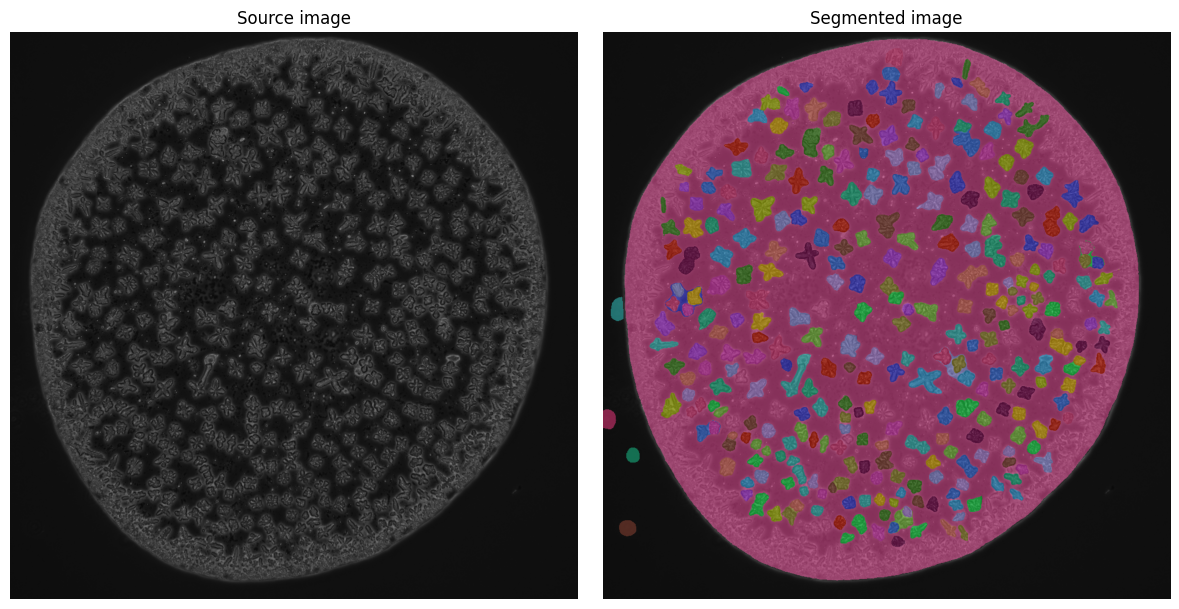

In [ ]:
# Sort detections by area in descending order
detections = sv.Detections.from_sam(sam_result=sam_result)
filtered_detections = detections # change for the one below to unsee the big drop
#filtered_detections = detections[detections.area != max(detections.area)]
# Annotate the image
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=filtered_detections)

# 2. Plot the side-by-side figure with matplotlib
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image_bgr)
axs[0].set_title('Source image')
axs[0].axis('off')
axs[1].imshow(annotated_image)
axs[1].set_title('Segmented image')
axs[1].axis('off')
plt.tight_layout()

# 3. Save figure
save_current_figure(figures_folder, '3. sam_segmented_vs_original')
plt.show()

4. If background detected -> Delete it (position 0 or 1)

In [ ]:
sam_result = remove_background(sam_result) # this function deletes background if in (0,0) the value is 1

Removed 1 background mask(s) touching the top-left corner.


In [ ]:
#sam_result = sam_result[1:]

4. Assuming SAM detected the drop: Separate first mask (drop) from the rest



 4.1. First option: get largest mask as the drop (works if you removed the background before)

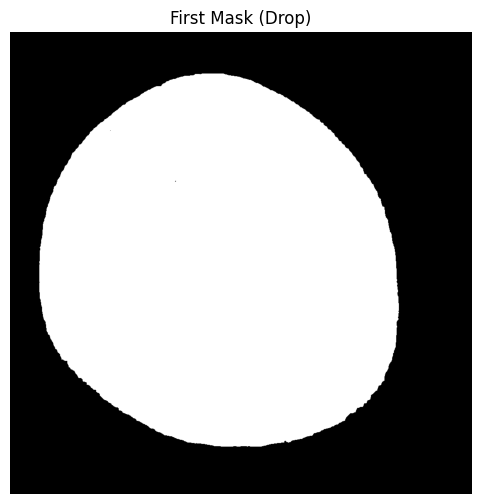

In [ ]:
sam_result = sorted(sam_result, key=lambda mask: mask['area'], reverse=True)

# Get the first (largest) mask - drop
drop = {
    'segmentation': sam_result[0]['segmentation'],
    'area': sam_result[0]['area'],
    'bbox': sam_result[0]['bbox']
}

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(drop['segmentation'], cmap='gray')
plt.title('First Mask (Drop)')
plt.axis('off')
plt.show()

# Info for next section (5)
drop_mask = sam_result[0]['segmentation']
# Get all masks from SAM
masks = sam_result[1:] #from 1 because 0 is the drop

4.2. Second option: select drop from all results based on area and circularity (can ignore background and then delete it with the filter outside mask)

Selected drop with area = 518890.0 and circularity = 0.83


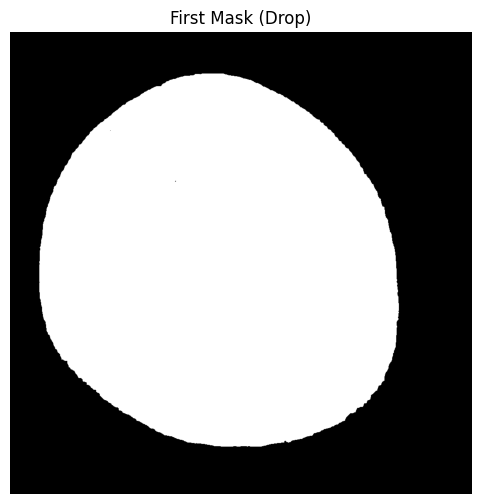

In [ ]:
drop, masks = extract_drop_from_sam_result(sam_result)

drop_mask = drop['segmentation']

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(drop['segmentation'], cmap='gray')
plt.title('First Mask (Drop)')
plt.axis('off')
plt.show()

4. If SAM didn't detect the drop: Post processing to find it

In [ ]:
#fill this

# for next section (5)
#drop_mask = ?
#masks = sam_result[0:] #from 0 because the drop was not detected

5. Filtering masks outside the drop

49 masks passed the 80% overlap threshold.
Saved figure: /content/segment_outputs/CNB_040425_05_20250601_0726/all_figures/5. before_after_drop_filtering.png


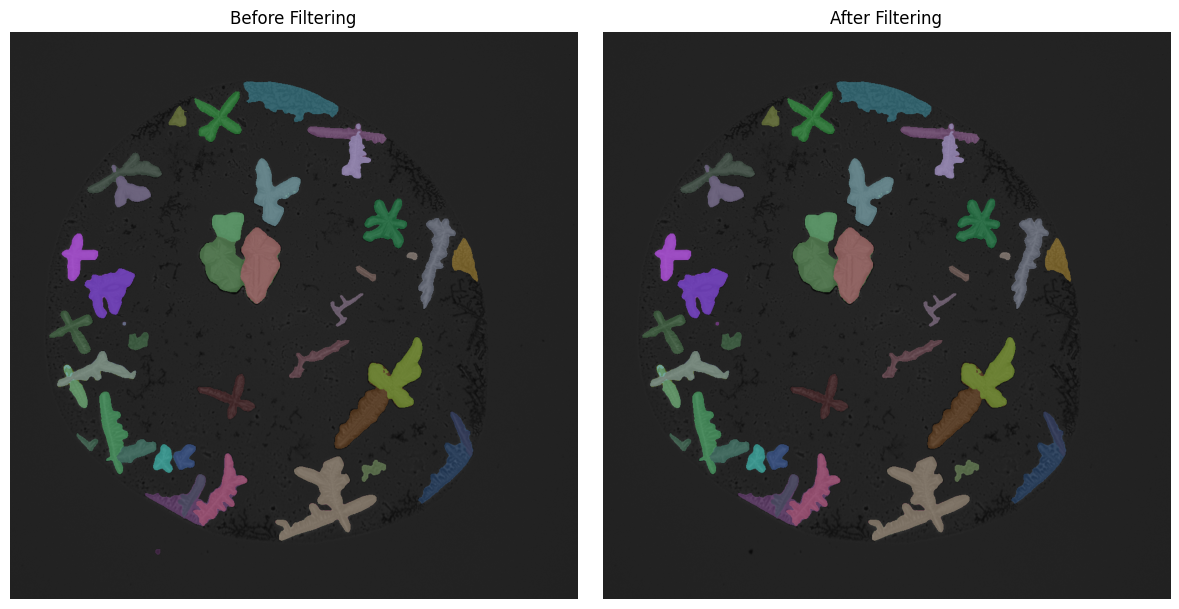

In [ ]:
masks_in_drop = remove_masks_outside_drop(drop['segmentation'], masks, overlap_threshold=0.8)

fig = before_after_og_image(image_bgr, masks, masks_in_drop,
                            title_before="Before Filtering",
                            title_after="After Filtering")

save_current_figure(figures_folder, '5. before_after_drop_filtering')

plt.show()

6. Filtering small masks

Total Masks: 49
Min Area: 32
Max Area: 14873
Mean Area: 3855.67
Median Area: 3148
25th Percentile: 1267
75th Percentile: 5239
Original mask count: 49
Filtered mask count (area ≥ 300): 46
Saved figure: /content/segment_outputs/CNB_040425_05_20250601_0726/all_figures/6. before_after_size_filtering.png


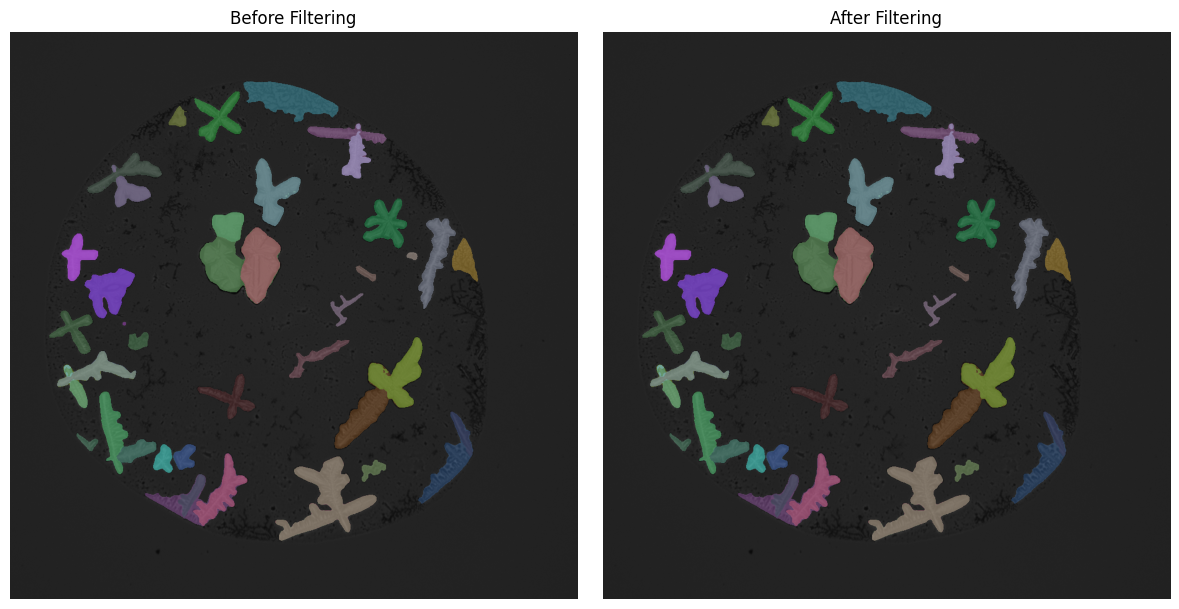

In [ ]:
# Step 1: Compute and print area stats (to decide threshold)
compute_area_stats(masks_in_drop)

# Step 2: Filter by area
area_threshold = 300
filtered_masks = filter_masks_by_area(masks_in_drop, min_area=area_threshold)

print(f"Original mask count: {len(masks_in_drop)}")
print(f"Filtered mask count (area ≥ {area_threshold}): {len(filtered_masks)}")

fig = before_after_og_image(image_bgr, masks_in_drop, filtered_masks,
                            title_before="Before Filtering",
                            title_after="After Filtering")

save_current_figure(figures_folder, '6. before_after_size_filtering')
plt.show()


7. Correcting masks that have separate components



Saved figure: /content/segment_outputs/CNB_040425_05_20250601_0726/all_figures/7.indexed_masks.png


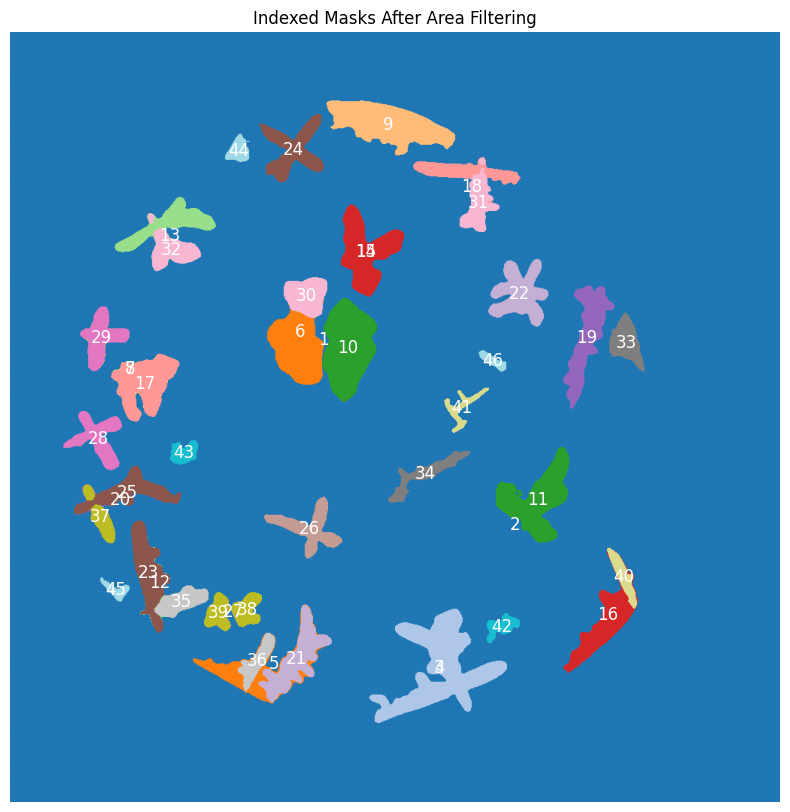


Mask cleanup summary:
- Original masks: 46
- Final cleaned masks: 48
- Masks that were split into components: 2


Saved figure: /content/segment_outputs/CNB_040425_05_20250601_0726/all_figures/7.split_mask_mask_7.png


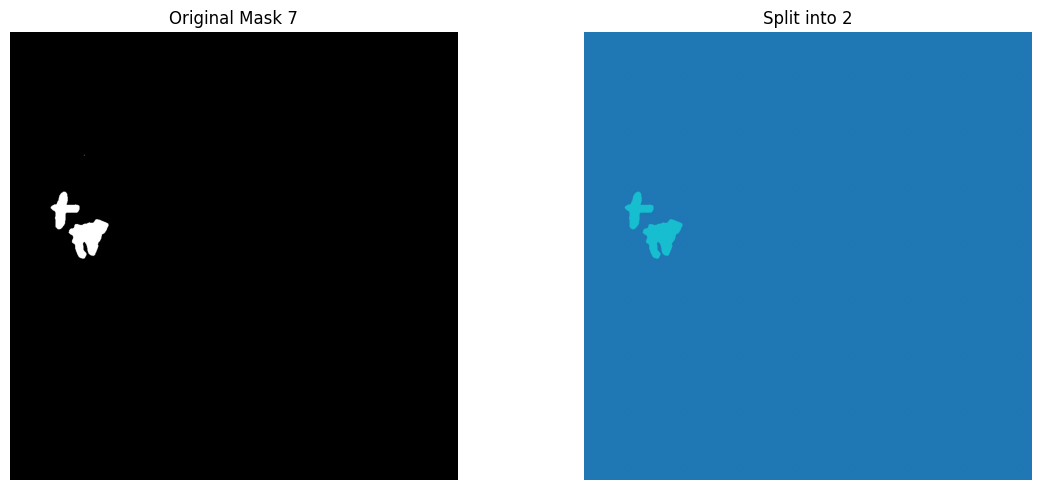

Saved figure: /content/segment_outputs/CNB_040425_05_20250601_0726/all_figures/7.split_mask_mask_8.png


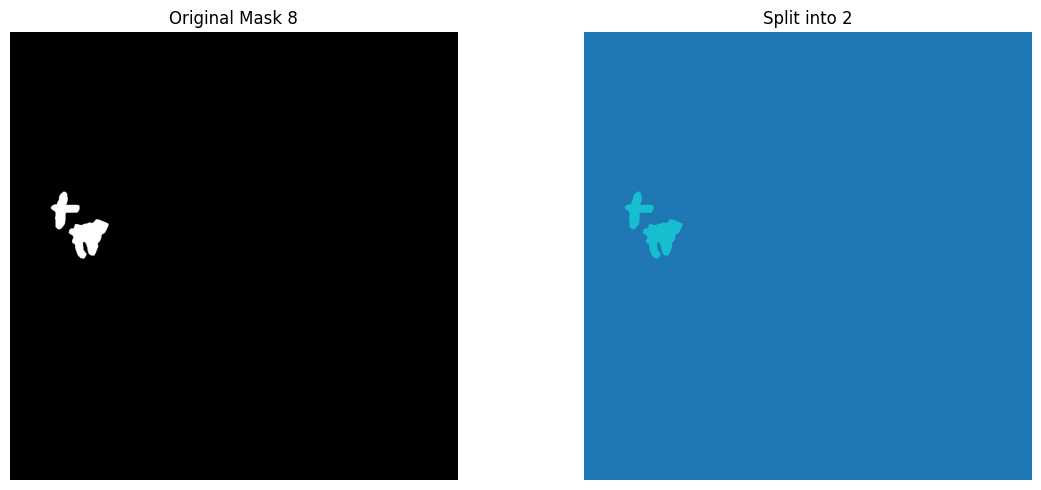

In [ ]:
fig = plot_indexed_masks(filtered_masks, title="Indexed Masks After Area Filtering")
save_current_figure(figures_folder, '7.indexed_masks')
plt.show()

separate_masks, masks_before_after = fix_separate_components(
    masks=filtered_masks,
    min_component_area=300,
    distance_threshold=80,
    min_total_area=300
)

plot_mask_component_splits(masks_before_after, figures_folder=figures_folder)

8. Joining masks that are too close

Fused 13 groups by adjacency.
Saved figure: /content/segment_outputs/CNB_040425_05_20250601_0726/all_figures/8.fused_masks.png


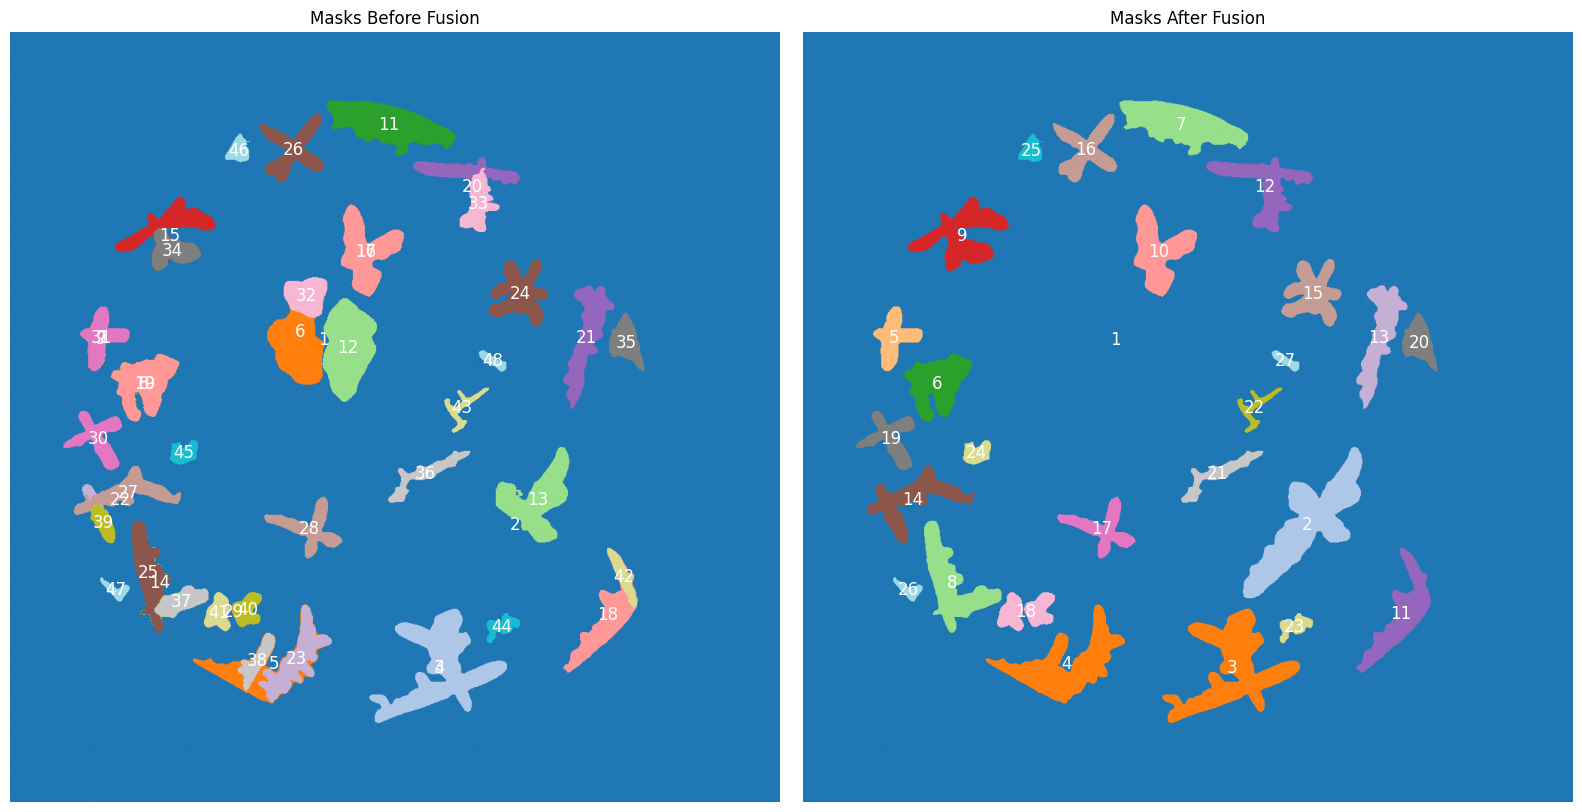

In [ ]:
# 1. Ejecutar la fusión por cercanía de bordes
fused_masks = merge_masks_by_proximity_new(separate_masks)
# fused_masks = merge_masks_by_proximity(separate_masks, merge_distance=0)

# 2. Visualizar comparativa antes vs. después (opcional)
fig = plot_mask_fusion_comparison(separate_masks, fused_masks)
save_current_figure(figures_folder, '8.fused_masks')
plt.show()

9. See final cleaned-up segmentation

Saved figure: /content/segment_outputs/CNB_040425_05_20250601_0726/all_figures/9.final_mask_overlay.png


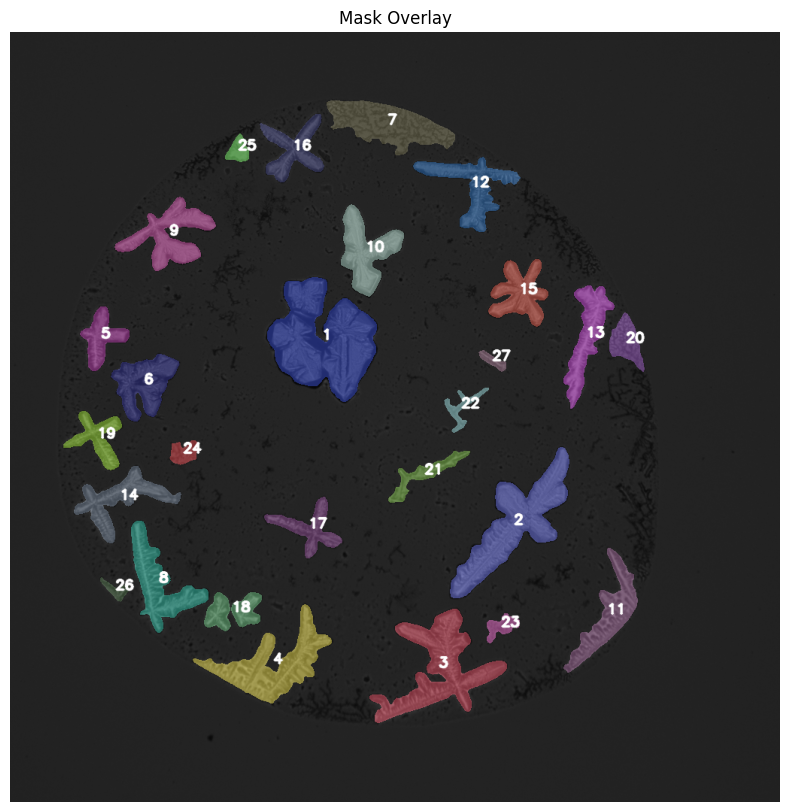

In [ ]:
fig = plot_masks_on_og_image(image_bgr, fused_masks)
save_current_figure(figures_folder, '9.final_mask_overlay')
plt.show()

10. Export information

In [ ]:
combined_segmentation = np.sum([mask['segmentation'] for mask in fused_masks], axis=0)
combined_segmentation[combined_segmentation > 1] = 1  # Ensure it's binary

export_segmentation_results(
    output_folder=output_folder,
    image_name=IMAGE_NAME,
    original_image_bytes=uploaded,
    drop=drop,
    masks=fused_masks,
    combined_mask=combined_segmentation
)